# Multi-layer perceptron for classifying handwritten digits

In this notebook I will be using one of MNIST datasets to train a linear multi-layer perceptron to classify handwritten digits.

In [1]:
import torch, torchvision
from torch import nn
from torchvision import datasets

import matplotlib.pyplot as plt
%matplotlib inline

### Fetch all the data

Yummy yummy data

In [2]:
train_data = datasets.MNIST(
    root=".datasets",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root=".datasets",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

### Lemmie show you all the data

Come with me, and you will see... A WORLD OF DATA ANALYTICS!

Image shape: torch.Size([1, 28, 28])


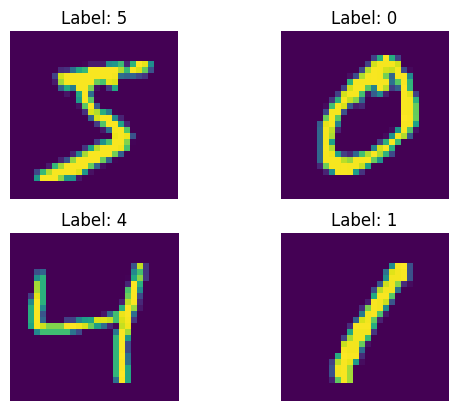

In [3]:
image, label = train_data[0]

print("Image shape:", image.shape)

for i in range(0, 4):
    image, label = train_data[i]
    plt.subplot(2, 2, i+1)
    plt.axis("off")
    plt.title(f"Label: {label}")
    plt.imshow(image.squeeze())

Now we turn all that data into a Python iterable. This just makes it possible to train it in a training loop, in batches too!

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79abb099adb0>,
 <torch.utils.data.dataloader.DataLoader at 0x79ac1ff251c0>)

### The model

The crown jewel of this notebook.

Might as well clarify one thing. The reason why I am more communicative in these notebooks is because computer vision is a lot more interesting than fitting data points or fitting SciKit-learn's toy datasets.

In [5]:
class MLPModelV0(nn.Module):
    def __init__(self, in_shape, hidden_units, out_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=out_shape)
        )
    
    def forward(self, X):
        return self.layer_stack.forward(X)

Another, rather cute thing you might notice (or not notice) is my naming scheme. It is from the course I learned all this. Here's the link to that course: https://www.udemy.com/course/pytorch-for-deep-learning/

Not sponsored haha.

In [6]:
torch.manual_seed(64)

# Now the in_shape value would be however much pixels we have
# So that is 28 x 28 which is equal to 784
# And 28 x 28 comes from image.shape

model = MLPModelV0(
    in_shape=28*28,
    hidden_units=10,
    out_shape=len(train_data.classes)
)

# model.state_dict()
# I am not showing all that! You can run that yourself. Otherwise my notebook will be pretty large due to the output.

Let's do a dummy forward pass. Just to make sure everything is going in there.

In [7]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

y_logits = model.forward(train_features_batch[0])
y_true = train_labels_batch[0]

y_pred = y_logits.argmax(dim=1)

print("Predicted:", y_pred.item())
print("True label:", y_true.item())

Predicted: 4
True label: 1


So that was... completly wrong. Which is expected because our model has randomized weights and biases. Let's set those up then.

### Let's train

In [8]:
from sklearn.metrics import accuracy_score

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
epochs = 8

# Look at the way I am writing the training and testing loop
# That is not the usual stuff! This is batches!

for epoch in range(epochs):
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_logits = model.forward(X)
        loss = loss_fn(y_logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    for batch, (X, y) in enumerate(test_dataloader):
        model.eval()
        with torch.inference_mode():
            y_logits = model.forward(X)
            y_pred = y_logits.argmax(dim=1)
            loss = loss_fn(y_logits, y)
        accuracy = accuracy_score(y, y_pred)
    
    print(f"Accuracy: {accuracy*100:.2f}% | Loss: {loss}")

Accuracy: 87.50% | Loss: 0.24748378992080688
Accuracy: 93.75% | Loss: 0.19348226487636566
Accuracy: 93.75% | Loss: 0.11859528720378876
Accuracy: 93.75% | Loss: 0.2476232796907425
Accuracy: 93.75% | Loss: 0.1640956699848175
Accuracy: 93.75% | Loss: 0.10577325522899628
Accuracy: 87.50% | Loss: 0.2908984422683716
Accuracy: 93.75% | Loss: 0.29814496636390686


Now that is pretty good. It is reasonable to believe something is up! So let's test it!

### Testing our model visually

Sample label: 7
Predicted label: 7


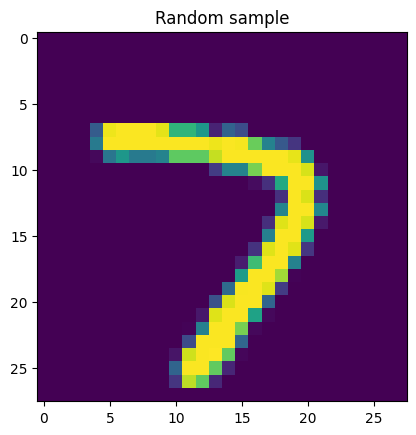

In [9]:
test_features_batch, test_labels_batch = next(iter(test_dataloader))

randi = torch.randint(0, len(test_labels_batch), (1,)).item()
image, label = test_features_batch[randi], test_labels_batch[randi]

model.eval()
with torch.inference_mode():
    y_logits = model.forward(image)
    y_pred = y_logits.argmax(dim=1)

print("Sample label:", label.item())
print("Predicted label:", y_pred.item())

plt.title("Random sample")
plt.imshow(image.squeeze())
plt.show()

And it is working splendidly! At `93.75%` accuracy. Although it still makes mistakes. The digits it makes mistakes at, I can't even recognise them, so we can caught it some slack.

It was fun!